# Which wine do I bring to the party ?

**Author**: Lucile Lapray

**Date**: October 2024

I'm not really a wine drinker, but there's such a fanbase for it that it's a social ability to know which wine to pick. If I could predict which wine is going to be delicious, I could bring a bottle to my in-laws without risking the ridicule.

**Objective**: Predict a wine's quality based on various physical features. Classifying problem.

I use a dataset describing red variants of the Portuguese "Vinho Verde" wine to test the concept.

# 1. Library import & initialisation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neural_network import MLPClassifier

In [3]:
def plot_sorted_coefficients(coef, threshold = 1e-08):
    """
    Plots a sorted scatter plot of logistic regression coefficients with different colors
    for positive, negative, and near-zero coefficients.
    
    Parameters:
    - coef: A pandas Series or array-like object containing coefficients.
    - threshold: A float value used to classify near-zero coefficients. Default is 1e-08.
    """

    # Sort the coefficients by their absolute values
    sorted_coef = coef.abs().sort_values()
    
    # Get the original coefficients for coloring
    original_sorted_coef = coef.loc[sorted_coef.index]
    
    # Create a scatter plot with bars
    plt.figure(figsize=(8, 32))
    
    # Plot positive coefficients in blue, negative coefficients in yellow, and near-zero coefficients in grey
    colors = [
        'grey' if abs(c) < threshold else 'blue' if c > 0 else 'yellow'
        for c in original_sorted_coef
    ]
    
    # Scatter plot for coefficients
    plt.scatter(sorted_coef.values, sorted_coef.index, color = colors, zorder = 5)
    
    # Plot lines from the origin to the scatter points
    for i in range(len(sorted_coef)):
        plt.plot([0, sorted_coef.values[i]], [i, i], color = 'skyblue', lw = 2)
    
    # Add vertical line at zero
    plt.axvline(x = 0, color = 'gray', linestyle = '--', linewidth = 1)
    
    # Set labels and title
    plt.xlabel('Absolute Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Logistic Regression Coefficients (Absolute Values)')
    
    # Show the plot
    plt.show()

In [4]:
sns.set_theme(context = 'notebook', style='darkgrid', palette='viridis', font='serif')

# 2. Data import

In [5]:
df = pd.read_csv("WineQT.csv")
display(df)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,2
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,3
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1592
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6,1593
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1594
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1595


# 3. Data description

In [28]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
 13  quality_class         1143 non-null   object 
dtypes: float64(11), int64(2), object(1)
memory usage: 125.1+ KB


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,5.657043,804.969379
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824,463.997116
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,5.000000,411.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,6.000000,794.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,6.000000,1209.500000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000,1597.000000


In [7]:
conditions = [
    (df['quality'].isin([3, 4])),  # disgusting: quality 3 and 4
    (df['quality'] == 5),          # mid: quality 5
    (df['quality'] == 6),          # acceptable: quality 6
    (df['quality'].isin([7, 8]))   # sensational: quality 7 and 8
]

categories_quality = ['disgusting', 'mid', 'acceptable', 'sensational']
df['quality_class'] = np.select(conditions, categories_quality, default="unknown")
df['quality_class'].value_counts()


quality_class
mid            483
acceptable     462
sensational    159
disgusting      39
Name: count, dtype: int64

C:\Users\lucil\AppData\Local\Temp\ipykernel_26164\3340615042.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = df['quality_class'], palette = 'viridis', order = categories_quality)


Text(0.5, 0, 'Quality of the wine: how does it taste?')

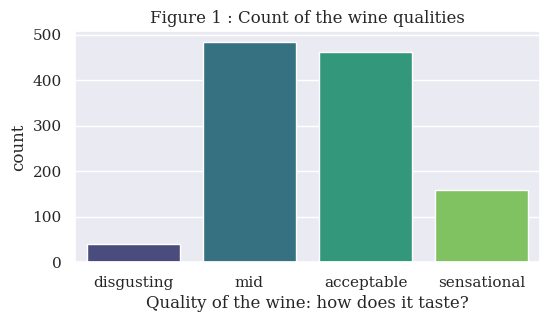

In [8]:
plt.figure(figsize=(6, 3))
sns.countplot(x = df['quality_class'], palette = 'viridis', order = categories_quality)
plt.title('Figure 1 : Count of the wine qualities')
plt.xlabel('Quality of the wine: how does it taste?')

# 4. Data standardization

In [9]:
# Separate the target variable from the rest of the dataset
y = df['quality_class']
features = df.drop(columns='quality_class')

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(features)

# Reconstruct the dataframe with scaled features and original target
df_scale = pd.DataFrame(X, columns=features.columns)
df_scale['quality_class'] = y.values  # Ensure target column is aligned
df_scale = df_scale.drop(columns=['quality', 'Id'])
df_scale.head(6)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_class
0,-0.521580,0.939332,-1.365027,-0.466421,-0.231395,-0.450467,-0.363610,0.555854,1.270695,-0.573658,-0.963382,mid
1,-0.292593,1.941813,-1.365027,0.050060,0.234247,0.915920,0.643477,0.036165,-0.708928,0.130881,-0.593601,mid
2,-0.292593,1.273492,-1.161568,-0.171289,0.107253,-0.060071,0.246745,0.140103,-0.325775,-0.045254,-0.593601,mid
3,1.653789,-1.399789,1.483400,-0.466421,-0.252560,0.135127,0.429852,0.659792,-0.964363,-0.456235,-0.593601,acceptable
4,-0.521580,0.939332,-1.365027,-0.466421,-0.231395,-0.450467,-0.363610,0.555854,1.270695,-0.573658,-0.963382,mid
5,-0.521580,0.716559,-1.365027,-0.540205,-0.252560,-0.255269,-0.180503,0.555854,1.270695,-0.573658,-0.963382,mid


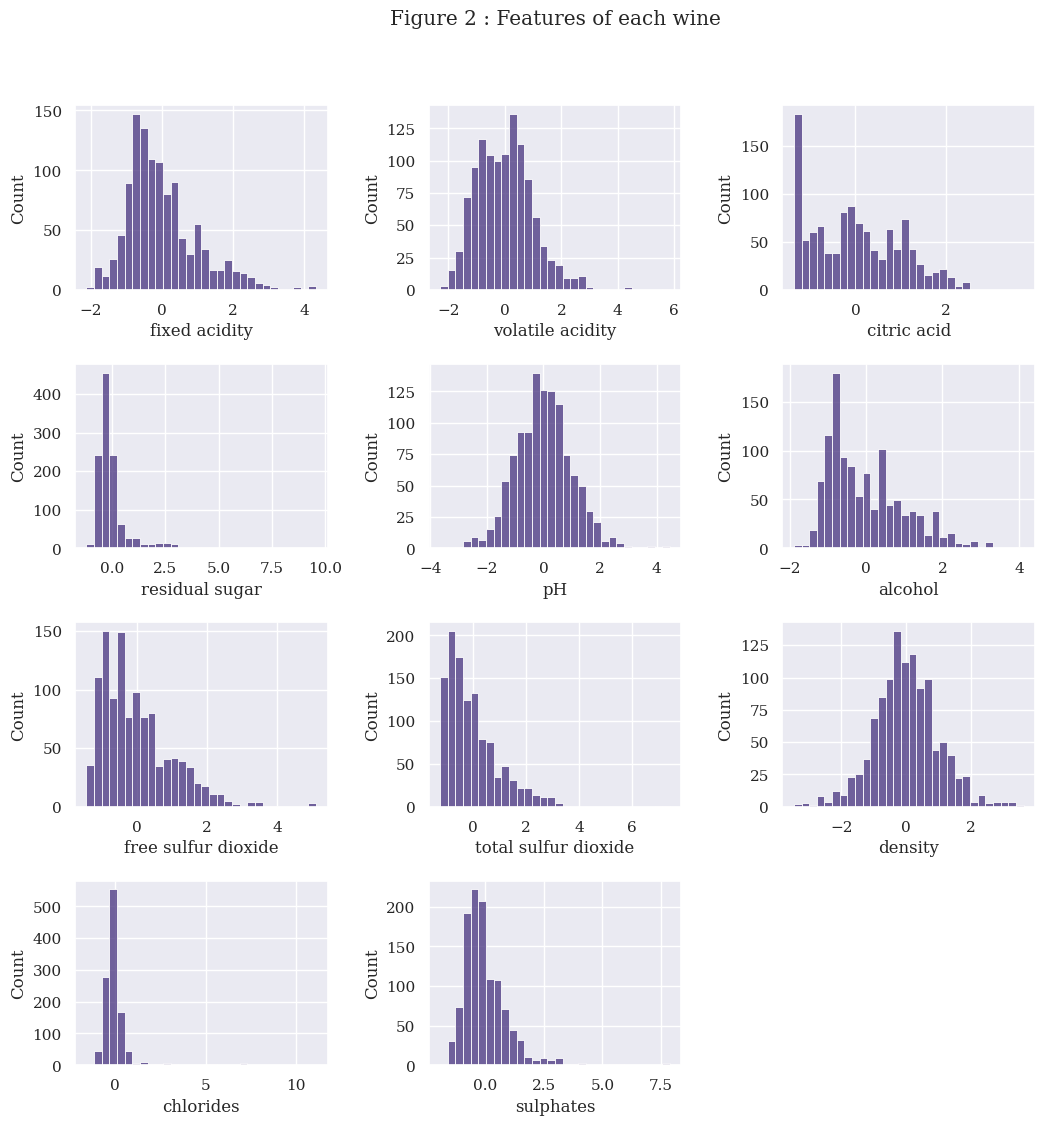

In [10]:
fig, axs = plt.subplots(4, 3, figsize=(12, 12))
fig.suptitle('Figure 2 : Features of each wine')

sns.histplot(x = df_scale['fixed acidity'], ax = axs[0, 0], bins = 30)
sns.histplot(x = df_scale['volatile acidity'], ax = axs[0, 1], bins = 30)
sns.histplot(x = df_scale['citric acid'], ax = axs[0, 2], bins = 30)

sns.histplot(x = df_scale['residual sugar'], ax = axs[1, 0], bins = 30)
sns.histplot(x = df_scale['pH'], ax=axs[1, 1], bins = 30)
sns.histplot(x = df_scale['alcohol'], ax = axs[1, 2], bins = 30)

sns.histplot(x = df_scale['free sulfur dioxide'], ax = axs[2, 0], bins = 30)
sns.histplot(x = df_scale['total sulfur dioxide'], ax = axs[2, 1], bins = 30)
sns.histplot(x = df_scale['density'], ax = axs[2, 2], bins = 30)

sns.histplot(x = df_scale['chlorides'], ax = axs[3, 0], bins = 30)
sns.histplot(x = df_scale['sulphates'], ax = axs[3, 1], bins = 30)
axs[3, 2].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

# 5. Train/test split

In [11]:
# Splitting the dataset into train and test, 80% and 20% since N>500
X = df_scale.drop("quality_class", axis = 1)
y = df_scale["quality_class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 666)

In [12]:
categories_quality_list = [['disgusting', 'mid', 'acceptable', 'sensational']]
encoder = OrdinalEncoder(categories=categories_quality_list)

df_scale['quality_class_encoded'] = encoder.fit_transform(df_scale[['quality_class']])
y_train_encoded = encoder.transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

c:\Users\lucil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(
c:\Users\lucil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OrdinalEncoder was fitted with feature names
  warnings.warn(


# 6. Data modelling

### 6.1 Logistic regression

In [13]:
# Perform logistic regression
reg = LogisticRegression(max_iter = 10000)
reg.fit(X_train, y_train_encoded.ravel())

# Extract coefficients
coefs_reg = pd.DataFrame(reg.coef_, columns=X_train.columns)
coefs_reg.index = [f"{categories_quality[i]}" for i in range(coefs_reg.shape[0])]
coefs_reg


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
disgusting,0.415211,0.780392,0.010917,0.165553,0.174492,-0.071468,-0.074407,-0.272462,0.516286,0.089325,-0.538389
mid,-0.523223,0.232895,0.191568,-0.129310,0.089432,-0.104969,0.357748,0.301708,-0.251233,-0.479926,-0.576754
acceptable,-0.079300,-0.265699,-0.272571,-0.168678,0.053849,0.072771,-0.037758,0.262634,-0.089203,0.005984,0.337470
sensational,0.187311,-0.747587,0.070086,0.132435,-0.317773,0.103666,-0.245583,-0.291880,-0.175850,0.384617,0.777673


In [14]:
y_pred_reg = reg.predict(X_test)
print(accuracy_score(y_test_encoded, y_pred_reg))

0.6157205240174672


In [15]:
cm = confusion_matrix(y_test_encoded, y_pred_reg)
cm_df = pd.DataFrame(cm, index = categories_quality, 
                     columns = ['Pred disgusting', 'Pred mid', 'Pred acceptable', 'Pred sensational'])
print("Confusion Matrix:")
print(cm_df)

Confusion Matrix:
             Pred disgusting  Pred mid  Pred acceptable  Pred sensational
disgusting                 0         6                1                 0
mid                        0        72               23                 2
acceptable                 0        34               57                10
sensational                0         1               11                12


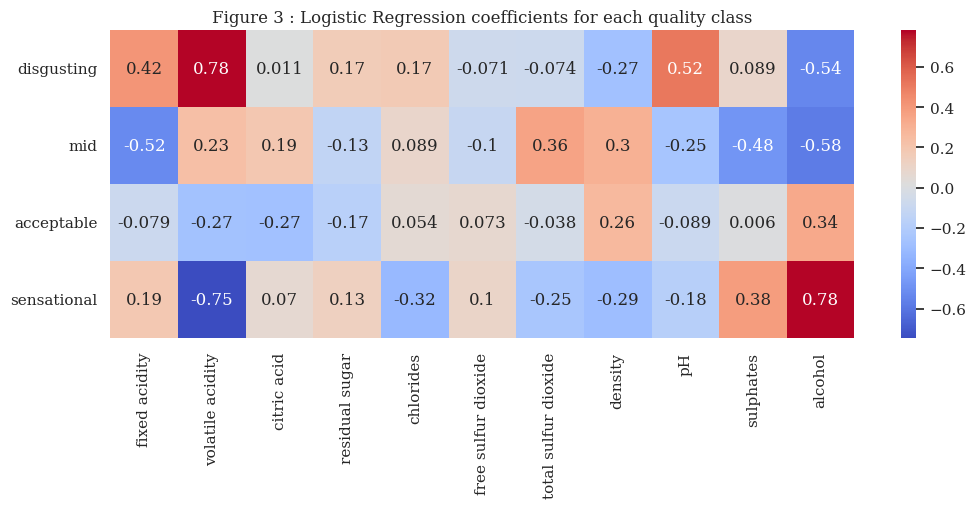

In [16]:
plt.figure(figsize=(12, 4))
sns.heatmap(coefs_reg, annot=True, cmap='coolwarm')
plt.title('Figure 3 : Logistic Regression coefficients for each quality class')
plt.show()

### 6.2 Logistic regression with L2 regularization

In [17]:
reg_regul = LogisticRegression(C = 0.01, solver = 'saga', penalty = 'l2', max_iter = 10000)
reg_regul.fit(X_train, y_train_encoded)
coefs_regul = pd.DataFrame(reg.coef_, columns=X_train.columns)

c:\Users\lucil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
y_pred_regul = reg_regul.predict(X_test)
print(accuracy_score(y_test_encoded, y_pred_regul))

0.6200873362445415


In [19]:
cm = confusion_matrix(y_test_encoded, y_pred_regul)
cm_df = pd.DataFrame(cm, index = categories_quality, 
                     columns = ['Pred disgusting', 'Pred mid', 'Pred acceptable', 'Pred sensational'])
print("Confusion Matrix:")
print(cm_df)

Confusion Matrix:
             Pred disgusting  Pred mid  Pred acceptable  Pred sensational
disgusting                 0         6                1                 0
mid                        0        74               23                 0
acceptable                 0        37               62                 2
sensational                0         1               17                 6


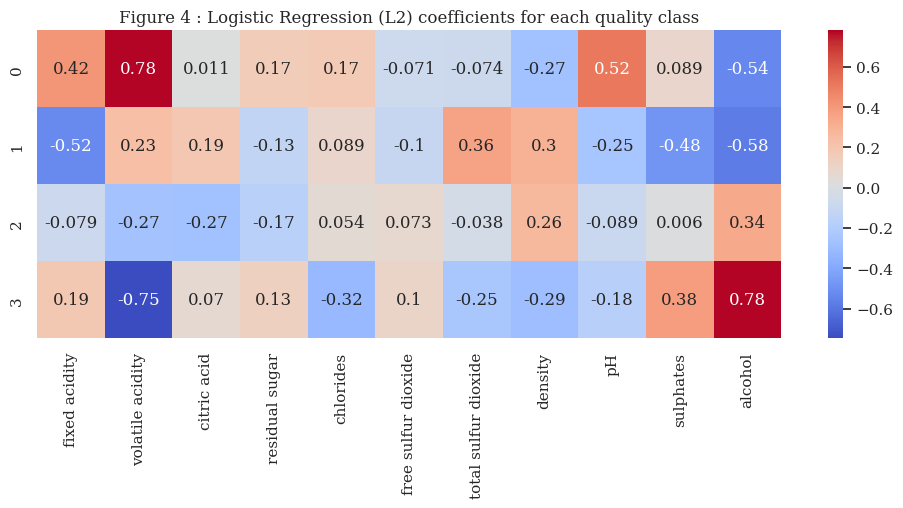

In [20]:
plt.figure(figsize=(12, 4))
sns.heatmap(coefs_regul, annot=True, cmap='coolwarm')
plt.title('Figure 4 : Logistic Regression (L2) coefficients for each quality class')
plt.show()

### 6.3 Random forest

In [21]:
# Construct the random forest
model = RandomForestClassifier(n_estimators = 1000, random_state = 666, max_depth = 20)
model.fit(X_train, y_train_encoded)

y_pred_random_forest = model.predict(X_test)
accuracy_score(y_test_encoded, y_pred_random_forest)

c:\Users\lucil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.7292576419213974

In [22]:
cm = confusion_matrix(y_test_encoded, y_pred_random_forest)
cm_df = pd.DataFrame(cm, index = categories_quality, 
                     columns = ['Pred disgusting', 'Pred mid', 'Pred acceptable', 'Pred sensational'])
print("Confusion Matrix:")
print(cm_df)

Confusion Matrix:
             Pred disgusting  Pred mid  Pred acceptable  Pred sensational
disgusting                 0         3                4                 0
mid                        0        74               22                 1
acceptable                 0        19               79                 3
sensational                0         1                9                14


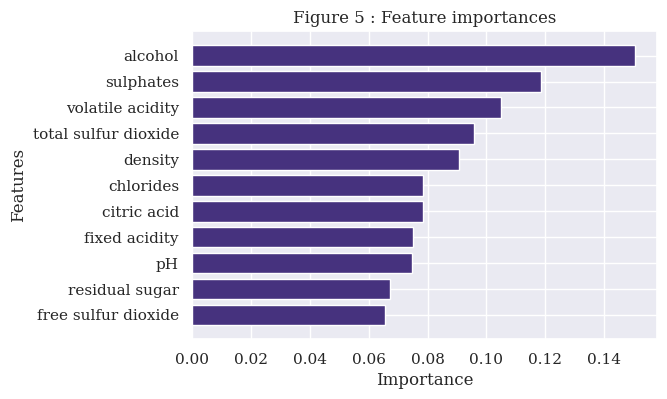

In [23]:
# Plot the feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(6, 4))
plt.title("Figure 5 : Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices], align = "center")
plt.yticks(ticks = range(X_train.shape[1]), labels = [X_train.columns[i] for i in indices])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.show()

### 6.5 Neural Network

In [24]:
clf_neurons = MLPClassifier(hidden_layer_sizes=(200, 100, 100), activation = 'relu',
                              solver='adam', max_iter = 4000, alpha=0.1, tol = 1e-6, batch_size= 500,
                              random_state = 666, verbose = True)

clf_neurons.fit(X_train, y_train_encoded)

c:\Users\lucil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 1.40457743
Iteration 2, loss = 1.28926177
Iteration 3, loss = 1.20956967
Iteration 4, loss = 1.14781724
Iteration 5, loss = 1.10469800
Iteration 6, loss = 1.06361801
Iteration 7, loss = 1.03004823
Iteration 8, loss = 1.00021345
Iteration 9, loss = 0.97210219
Iteration 10, loss = 0.95198304
Iteration 11, loss = 0.94073132
Iteration 12, loss = 0.93406726
Iteration 13, loss = 0.92472432
Iteration 14, loss = 0.91229116
Iteration 15, loss = 0.90131498
Iteration 16, loss = 0.89316169
Iteration 17, loss = 0.88558832
Iteration 18, loss = 0.87595903
Iteration 19, loss = 0.86707567
Iteration 20, loss = 0.85948405
Iteration 21, loss = 0.85291088
Iteration 22, loss = 0.84603946
Iteration 23, loss = 0.83991503
Iteration 24, loss = 0.83308141
Iteration 25, loss = 0.82720374
Iteration 26, loss = 0.81994577
Iteration 27, loss = 0.81254224
Iteration 28, loss = 0.80776344
Iteration 29, loss = 0.80113042
Iteration 30, loss = 0.79385383
Iteration 31, loss = 0.79035905
Iteration 32, los

MLPClassifier(alpha=0.1, batch_size=500, hidden_layer_sizes=(200, 100, 100),
              max_iter=4000, random_state=666, tol=1e-06, verbose=True)

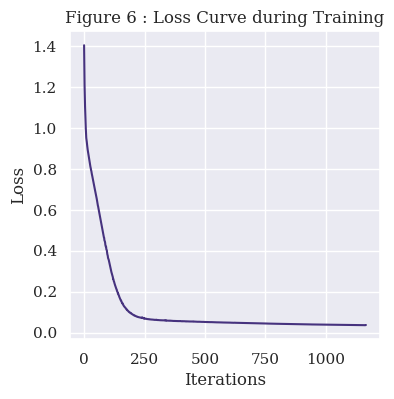

In [25]:
plt.figure(figsize = (4, 4))
plt.plot(clf_neurons.loss_curve_)
plt.title('Figure 6 : Loss Curve during Training')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [26]:
y_pred_neurons = clf_neurons.predict(X_test)
print(accuracy_score(y_test_encoded, y_pred_neurons))

0.6724890829694323


In [27]:
cm = confusion_matrix(y_test_encoded, y_pred_neurons)
cm_df = pd.DataFrame(cm, index = categories_quality, 
                     columns = ['Pred disgusting', 'Pred mid', 'Pred acceptable', 'Pred sensational'])
print("Confusion Matrix:")
print(cm_df)

Confusion Matrix:
             Pred disgusting  Pred mid  Pred acceptable  Pred sensational
disgusting                 0         4                3                 0
mid                        4        75               13                 5
acceptable                 1        28               63                 9
sensational                0         0                8                16


# 7. Conclusion

The grade given by specialists on the quality of wine (divided in 4 categories) can be predicted with an accuracy of 72.9% using a Random Forest algorithm. This is better than the predictions made by a neural network (accuracy of 67.2%) or made by the Logistic Regression, with or without regularization (accuracy of 61.5% or 62.0%).

To take this a step further, it might be interesting to get means of different quality evaluations form several judges in order to reduce the subjective inducements of taste.